In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 92)
(734160, 1)
validation
(101248, 92)
(101248, 1)
test
(100432, 92)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:23 - loss: 0.0150 - STD: 1.8891e-05 - MAE: 0.0905

 7/74 [=>............................] - ETA: 0s - loss: 0.0109 - STD: 2.8308e-05 - MAE: 0.0806  

13/74 [====>.........................] - ETA: 0s - loss: 0.0102 - STD: 4.3721e-05 - MAE: 0.0791

19/74 [======>.......................] - ETA: 0s - loss: 0.0100 - STD: 6.6431e-05 - MAE: 0.0783

25/74 [=========>....................] - ETA: 0s - loss: 0.0099 - STD: 9.0461e-05 - MAE: 0.0776

31/74 [===========>..................] - ETA: 0s - loss: 0.0098 - STD: 1.1758e-04 - MAE: 0.0774

37/74 [==============>...............] - ETA: 0s - loss: 0.0097 - STD: 1.4541e-04 - MAE: 0.0770

43/74 [================>.............] - ETA: 0s - loss: 0.0096 - STD: 1.7601e-04 - MAE: 0.0768

49/74 [==================>...........] - ETA: 0s - loss: 0.0096 - STD: 2.1069e-04 - MAE: 0.0766

55/74 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 2.4977e-04 - MAE: 0.0765

61/74 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 2.9500e-04 - MAE: 0.0763

67/74 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 3.4984e-04 - MAE: 0.0762

69/74 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 3.7091e-04 - MAE: 0.0762

74/74 [==============================] - 3s 24ms/step - loss: 0.0094 - STD: 4.2986e-04 - MAE: 0.0761 - val_loss: 0.0085 - val_STD: 0.0011 - val_MAE: 0.0714


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0088 - STD: 0.0014 - MAE: 0.0740

 7/74 [=>............................] - ETA: 0s - loss: 0.0089 - STD: 0.0017 - MAE: 0.0743

13/74 [====>.........................] - ETA: 0s - loss: 0.0090 - STD: 0.0019 - MAE: 0.0745

19/74 [======>.......................] - ETA: 0s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0745

25/74 [=========>....................] - ETA: 0s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0744

32/74 [===========>..................] - ETA: 0s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0741

38/74 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0738

44/74 [================>.............] - ETA: 0s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0734

50/74 [===================>..........] - ETA: 0s - loss: 0.0085 - STD: 0.0096 - MAE: 0.0727

56/74 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0129 - MAE: 0.0719

62/74 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0165 - MAE: 0.0712

68/74 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0196 - MAE: 0.0707

74/74 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.0222 - MAE: 0.0702

74/74 [==============================] - 1s 10ms/step - loss: 0.0080 - STD: 0.0222 - MAE: 0.0702 - val_loss: 0.0056 - val_STD: 0.0373 - val_MAE: 0.0555


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0069 - STD: 0.0462 - MAE: 0.0627

 7/74 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0476 - MAE: 0.0631

13/74 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0474 - MAE: 0.0633

19/74 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0475 - MAE: 0.0632

26/74 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0481 - MAE: 0.0631

32/74 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0487 - MAE: 0.0631

38/74 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0490 - MAE: 0.0631

44/74 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0493 - MAE: 0.0631

51/74 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0496 - MAE: 0.0631

57/74 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0497 - MAE: 0.0631

63/74 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0498 - MAE: 0.0630

69/74 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0499 - MAE: 0.0629

74/74 [==============================] - 1s 10ms/step - loss: 0.0066 - STD: 0.0500 - MAE: 0.0629 - val_loss: 0.0055 - val_STD: 0.0416 - val_MAE: 0.0575


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0515 - MAE: 0.0644

 7/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0513 - MAE: 0.0627

13/74 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0515 - MAE: 0.0626

20/74 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0515 - MAE: 0.0625

26/74 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0514 - MAE: 0.0625

32/74 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0625

38/74 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0625

44/74 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0625

51/74 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0625

58/74 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0625

65/74 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0625

71/74 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0625

74/74 [==============================] - 1s 10ms/step - loss: 0.0065 - STD: 0.0514 - MAE: 0.0625 - val_loss: 0.0053 - val_STD: 0.0410 - val_MAE: 0.0548


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0513 - MAE: 0.0614

 7/74 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0623

13/74 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0522 - MAE: 0.0622

19/74 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0524 - MAE: 0.0623

25/74 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0622

32/74 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0522 - MAE: 0.0623

38/74 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0521 - MAE: 0.0622

45/74 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0621

51/74 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0621

57/74 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0621

63/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0621

70/74 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0621

74/74 [==============================] - 1s 10ms/step - loss: 0.0065 - STD: 0.0520 - MAE: 0.0621 - val_loss: 0.0053 - val_STD: 0.0415 - val_MAE: 0.0552


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0624

 7/74 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0517 - MAE: 0.0622

13/74 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0518 - MAE: 0.0621

19/74 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0518 - MAE: 0.0619

26/74 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0620

32/74 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0620

38/74 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0620

44/74 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0621

50/74 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0620

56/74 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0621

62/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0621

68/74 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0621

74/74 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0621

74/74 [==============================] - 1s 10ms/step - loss: 0.0065 - STD: 0.0519 - MAE: 0.0621 - val_loss: 0.0053 - val_STD: 0.0421 - val_MAE: 0.0555


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0522 - MAE: 0.0626

 7/74 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0619

14/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0618

20/74 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

26/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0618

32/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0618

39/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0524 - MAE: 0.0618

45/74 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0523 - MAE: 0.0619

51/74 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0619

57/74 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0620

64/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0620

71/74 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0522 - MAE: 0.0620

74/74 [==============================] - 1s 9ms/step - loss: 0.0065 - STD: 0.0522 - MAE: 0.0620 - val_loss: 0.0053 - val_STD: 0.0426 - val_MAE: 0.0560


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0625

 7/74 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

13/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0532 - MAE: 0.0617

19/74 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0618

25/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0619

32/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0619

39/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0618

45/74 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0619

51/74 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0619

57/74 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0524 - MAE: 0.0619

63/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0619

69/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0619

74/74 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0525 - MAE: 0.0619 - val_loss: 0.0052 - val_STD: 0.0420 - val_MAE: 0.0541


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0518 - MAE: 0.0610

 7/74 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0520 - MAE: 0.0616

14/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0521 - MAE: 0.0618

20/74 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0524 - MAE: 0.0618

26/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0618

32/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0617

39/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0617

45/74 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

51/74 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

57/74 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

63/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

69/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

74/74 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0528 - MAE: 0.0617 - val_loss: 0.0052 - val_STD: 0.0428 - val_MAE: 0.0544


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0534 - MAE: 0.0619

 7/74 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0531 - MAE: 0.0618

13/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

20/74 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

27/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0615

33/74 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

40/74 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0617

47/74 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0616

54/74 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0616

61/74 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

67/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

74/74 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

74/74 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616 - val_loss: 0.0052 - val_STD: 0.0424 - val_MAE: 0.0537


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0520 - MAE: 0.0602

 7/74 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0526 - MAE: 0.0619

13/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0617

19/74 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0618

25/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0617

31/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0617

37/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0617

43/74 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

50/74 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0617

56/74 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

62/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

68/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

74/74 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

74/74 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616 - val_loss: 0.0051 - val_STD: 0.0432 - val_MAE: 0.0542


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0611

 7/74 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0535 - MAE: 0.0617

13/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0615

19/74 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0615

25/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0615

31/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0616

37/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0615

44/74 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0614

50/74 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0615

56/74 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0615

62/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0615

68/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0615

74/74 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0534 - MAE: 0.0614 - val_loss: 0.0052 - val_STD: 0.0436 - val_MAE: 0.0546


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0615

 7/74 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0536 - MAE: 0.0616

13/74 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0536 - MAE: 0.0615

19/74 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0538 - MAE: 0.0616

25/74 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0537 - MAE: 0.0616

31/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0535 - MAE: 0.0616

37/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0532 - MAE: 0.0616

43/74 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

49/74 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0616

55/74 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

62/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

68/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0617

74/74 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0617

74/74 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0529 - MAE: 0.0617 - val_loss: 0.0055 - val_STD: 0.0432 - val_MAE: 0.0579


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0539 - MAE: 0.0630

 8/74 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0617

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0531 - MAE: 0.0615

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0613

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0614

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0614

39/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0614

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0615

51/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0614

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0614

64/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0615

71/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0614

74/74 [==============================] - 1s 10ms/step - loss: 0.0063 - STD: 0.0534 - MAE: 0.0614 - val_loss: 0.0051 - val_STD: 0.0437 - val_MAE: 0.0542


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0606

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0612

13/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0612

19/74 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0613

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0612

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0613

40/74 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0614

46/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0614

52/74 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0537 - MAE: 0.0614

58/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0614

65/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0614

72/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0614

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0536 - MAE: 0.0614 - val_loss: 0.0051 - val_STD: 0.0420 - val_MAE: 0.0530


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0515 - MAE: 0.0612

 8/74 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0530 - MAE: 0.0613

15/74 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0613

21/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0613

27/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0614

34/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0613

40/74 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0614

47/74 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0613

53/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0613

59/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0613

65/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0613

71/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0613

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0536 - MAE: 0.0613 - val_loss: 0.0052 - val_STD: 0.0445 - val_MAE: 0.0553


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0546 - MAE: 0.0618

 7/74 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0545 - MAE: 0.0613

13/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0545 - MAE: 0.0612

19/74 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0544 - MAE: 0.0614

25/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0613

31/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0613

37/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0613

44/74 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0613

51/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0613

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0613

64/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0613

70/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613

74/74 [==============================] - 1s 10ms/step - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613 - val_loss: 0.0051 - val_STD: 0.0435 - val_MAE: 0.0538


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0608

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0613

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0613

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613

32/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0612

38/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0612

44/74 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613

50/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613

56/74 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613

62/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0613

69/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0613

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0539 - MAE: 0.0613 - val_loss: 0.0051 - val_STD: 0.0443 - val_MAE: 0.0547


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0546 - MAE: 0.0620

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0613

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0613

21/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0614

28/74 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0616

34/74 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0533 - MAE: 0.0616

41/74 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0617

47/74 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0616

53/74 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0616

59/74 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616

65/74 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0531 - MAE: 0.0616

71/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0531 - MAE: 0.0616

74/74 [==============================] - 1s 9ms/step - loss: 0.0064 - STD: 0.0530 - MAE: 0.0616 - val_loss: 0.0051 - val_STD: 0.0431 - val_MAE: 0.0544


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0612

 8/74 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0611

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0611

27/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0611

39/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0611

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

52/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

58/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

64/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

71/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612 - val_loss: 0.0052 - val_STD: 0.0442 - val_MAE: 0.0549


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0544 - MAE: 0.0616

 8/74 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0543 - MAE: 0.0614

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0611

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0612

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0612

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

40/74 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

46/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0613

52/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0613

59/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0612

66/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0612

73/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0538 - MAE: 0.0612 - val_loss: 0.0051 - val_STD: 0.0446 - val_MAE: 0.0547


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0549 - MAE: 0.0620

 6/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0545 - MAE: 0.0612

13/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0612

19/74 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

25/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

32/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

38/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

52/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

59/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

66/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

73/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0612

74/74 [==============================] - 1s 10ms/step - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611 - val_loss: 0.0051 - val_STD: 0.0435 - val_MAE: 0.0536


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0612

 7/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0610

14/74 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0610

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0610

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0611

32/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0611

38/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0611

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612

51/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

64/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

70/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612 - val_loss: 0.0051 - val_STD: 0.0442 - val_MAE: 0.0545


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0609

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0611

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612

32/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

38/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

44/74 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

50/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

63/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

69/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

74/74 [==============================] - 1s 10ms/step - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611 - val_loss: 0.0050 - val_STD: 0.0437 - val_MAE: 0.0536


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0603

 7/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0609

13/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

19/74 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

25/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0611

31/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

37/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

43/74 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0612

49/74 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612

55/74 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612

61/74 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0612

67/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0612

73/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612

74/74 [==============================] - 1s 10ms/step - loss: 0.0063 - STD: 0.0539 - MAE: 0.0612 - val_loss: 0.0050 - val_STD: 0.0428 - val_MAE: 0.0526


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0600

 8/74 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0609

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0610

21/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

27/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0609

39/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0610

46/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0544 - MAE: 0.0610

52/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0610

58/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

65/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

71/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0610

74/74 [==============================] - 1s 10ms/step - loss: 0.0063 - STD: 0.0543 - MAE: 0.0610 - val_loss: 0.0050 - val_STD: 0.0435 - val_MAE: 0.0537


Epoch 27/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0533 - MAE: 0.0603

 8/74 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0606

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0608

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

27/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0610

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0610

39/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

51/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

64/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

70/74 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

74/74 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610 - val_loss: 0.0051 - val_STD: 0.0444 - val_MAE: 0.0541


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0541 - MAE: 0.0614

 8/74 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0548 - MAE: 0.0609

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0549 - MAE: 0.0609

21/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0611

27/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0611

33/74 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0611

39/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0611

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0611

51/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

64/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0610

70/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0609

74/74 [==============================] - 1s 9ms/step - loss: 0.0062 - STD: 0.0544 - MAE: 0.0609 - val_loss: 0.0050 - val_STD: 0.0426 - val_MAE: 0.0523


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0517 - MAE: 0.0603

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0613

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0612

20/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0612

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0612

32/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0611

38/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0611

44/74 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

50/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

56/74 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0610

62/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0610

68/74 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0609

74/74 [==============================] - 1s 10ms/step - loss: 0.0062 - STD: 0.0543 - MAE: 0.0609 - val_loss: 0.0052 - val_STD: 0.0466 - val_MAE: 0.0561


Epoch 30/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0563 - MAE: 0.0627

 7/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0609

13/74 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0606

19/74 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0608

25/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0608

31/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0607

37/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0607

43/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0606

49/74 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0607

55/74 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0608

61/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0608

67/74 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0607

74/74 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0607

74/74 [==============================] - 1s 10ms/step - loss: 0.0062 - STD: 0.0545 - MAE: 0.0607 - val_loss: 0.0053 - val_STD: 0.0470 - val_MAE: 0.0564


Epoch 31/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0569 - MAE: 0.0618

 8/74 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0544 - MAE: 0.0610

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0610

20/74 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0609

26/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0608

33/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0607

39/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0607

46/74 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0606

52/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0606

58/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0606

64/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0606

70/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0605

74/74 [==============================] - 1s 9ms/step - loss: 0.0062 - STD: 0.0547 - MAE: 0.0605 - val_loss: 0.0057 - val_STD: 0.0490 - val_MAE: 0.0595


Epoch 32/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0592 - MAE: 0.0638

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0616

13/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0613

19/74 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0611

25/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0611

31/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0610

37/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0609

44/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0608

51/74 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0608

57/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0607

63/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0607

70/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0606

74/74 [==============================] - 1s 10ms/step - loss: 0.0062 - STD: 0.0545 - MAE: 0.0606 - val_loss: 0.0049 - val_STD: 0.0467 - val_MAE: 0.0535


Epoch 33/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0599

 8/74 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0600

14/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0602

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0600

27/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0601

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0601

41/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0602

47/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0602

54/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0602

60/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0602

66/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0602

72/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0602

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0552 - MAE: 0.0602 - val_loss: 0.0049 - val_STD: 0.0470 - val_MAE: 0.0532


Epoch 34/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

 7/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0562 - MAE: 0.0604

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0602

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0601

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0602

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0601

38/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

44/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

50/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

57/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

70/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0554 - MAE: 0.0601 - val_loss: 0.0051 - val_STD: 0.0479 - val_MAE: 0.0547


Epoch 35/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0607

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0599

14/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0600

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0601

26/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0601

33/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0602

40/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0602

47/74 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0603

54/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0604

61/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0603

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0603

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0602

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0550 - MAE: 0.0602 - val_loss: 0.0049 - val_STD: 0.0469 - val_MAE: 0.0525


Epoch 36/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0552 - MAE: 0.0611

 7/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0601

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0600

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0602

25/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0603

32/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0602

39/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0602

45/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0602

51/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0601

57/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0601

63/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0601

69/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0601

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0553 - MAE: 0.0601 - val_loss: 0.0049 - val_STD: 0.0457 - val_MAE: 0.0520


Epoch 37/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0536 - MAE: 0.0595

 7/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0608

14/74 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0607

20/74 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0607

27/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0606

33/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0605

39/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0604

46/74 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0604

52/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0603

59/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0603

65/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0602

71/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0601

74/74 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0551 - MAE: 0.0601 - val_loss: 0.0050 - val_STD: 0.0488 - val_MAE: 0.0537


Epoch 38/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0593

 8/74 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0598

15/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

21/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

27/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0598

33/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

39/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

52/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

59/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

65/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

71/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

74/74 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599 - val_loss: 0.0049 - val_STD: 0.0473 - val_MAE: 0.0525


Epoch 39/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0544 - MAE: 0.0603

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0600

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0600

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0600

27/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0599

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

40/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

52/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

58/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

70/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599 - val_loss: 0.0048 - val_STD: 0.0470 - val_MAE: 0.0520


Epoch 40/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0593

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0600

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0599

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

37/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

43/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

55/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

61/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

74/74 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599 - val_loss: 0.0050 - val_STD: 0.0482 - val_MAE: 0.0535


Epoch 41/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0597

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0563 - MAE: 0.0598

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0599

27/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

41/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

48/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

55/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

61/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

74/74 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599 - val_loss: 0.0049 - val_STD: 0.0480 - val_MAE: 0.0526


Epoch 42/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0597

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

14/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0599

26/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0598

32/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0598

38/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

44/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598

50/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598

56/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598

62/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

74/74 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598 - val_loss: 0.0050 - val_STD: 0.0477 - val_MAE: 0.0537


Epoch 43/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0601

 8/74 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0599

15/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

22/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

28/74 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0598

40/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

47/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

54/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0599

61/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599

74/74 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0557 - MAE: 0.0599 - val_loss: 0.0049 - val_STD: 0.0458 - val_MAE: 0.0517


Epoch 44/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0533 - MAE: 0.0593

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0600

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0601

20/74 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0553 - MAE: 0.0603

27/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0554 - MAE: 0.0602

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0602

41/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0601

47/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0601

53/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0600

60/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0600

66/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0600

72/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0599

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0555 - MAE: 0.0600 - val_loss: 0.0048 - val_STD: 0.0470 - val_MAE: 0.0520


Epoch 45/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0546 - MAE: 0.0582

 7/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0597

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0597

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0598

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598

32/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

38/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597

45/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

51/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

58/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0598

70/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0598

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0559 - MAE: 0.0598 - val_loss: 0.0048 - val_STD: 0.0470 - val_MAE: 0.0520


Epoch 46/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0589

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0599

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0599

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

32/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

38/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0599

44/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

50/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

56/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0597

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597 - val_loss: 0.0048 - val_STD: 0.0475 - val_MAE: 0.0523


Epoch 47/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0592

 8/74 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

14/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

26/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0597

32/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0597

44/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0597

50/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0597

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

74/74 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597 - val_loss: 0.0049 - val_STD: 0.0488 - val_MAE: 0.0526


Epoch 48/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0594

 7/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0593

13/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0594

19/74 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0595

26/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0595

33/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0595

40/74 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0597

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0598

52/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

58/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

64/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

71/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

74/74 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597 - val_loss: 0.0048 - val_STD: 0.0477 - val_MAE: 0.0522


Epoch 49/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0559 - MAE: 0.0588

 7/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0593

14/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0595

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0598

26/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0601

33/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0601

40/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0600

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0599

53/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0599

59/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0599

66/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0598

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598

74/74 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0557 - MAE: 0.0598 - val_loss: 0.0049 - val_STD: 0.0485 - val_MAE: 0.0531


Epoch 50/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0601

 7/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0594

13/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0595

19/74 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0596

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0598

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597

37/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

43/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

50/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597

57/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0597

63/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

69/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

74/74 [==============================] - 1s 10ms/step - loss: 0.0060 - STD: 0.0560 - MAE: 0.0596 - val_loss: 0.0048 - val_STD: 0.0475 - val_MAE: 0.0522


Epoch 51/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0600

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0597

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0598

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

25/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0596

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

37/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597

43/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0597

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597

55/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

61/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0597

73/74 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0560 - MAE: 0.0597 - val_loss: 0.0050 - val_STD: 0.0496 - val_MAE: 0.0536


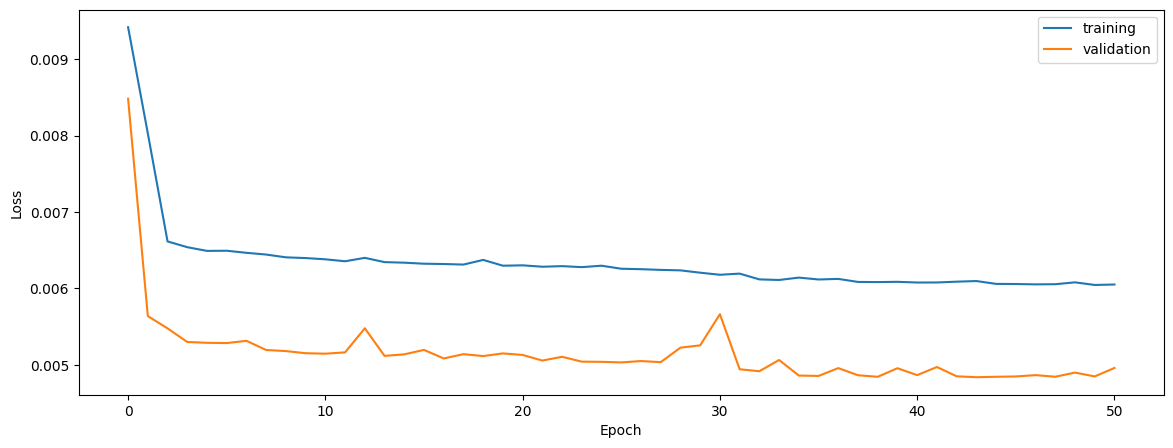

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.5874694014925423
0.6638597790660662
0.5977698636658031


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.5874694014925423
0.6638597790660662
0.5977698636658031


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.5796584915127114
0.6669384447244269
0.5904672855681377


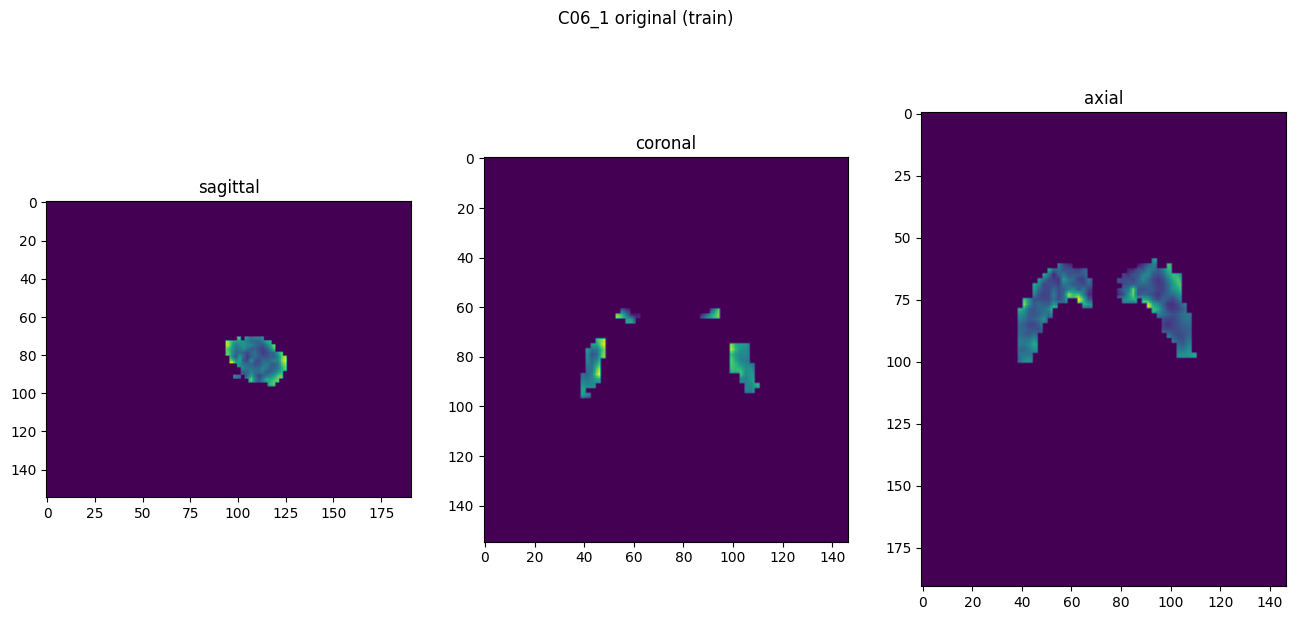

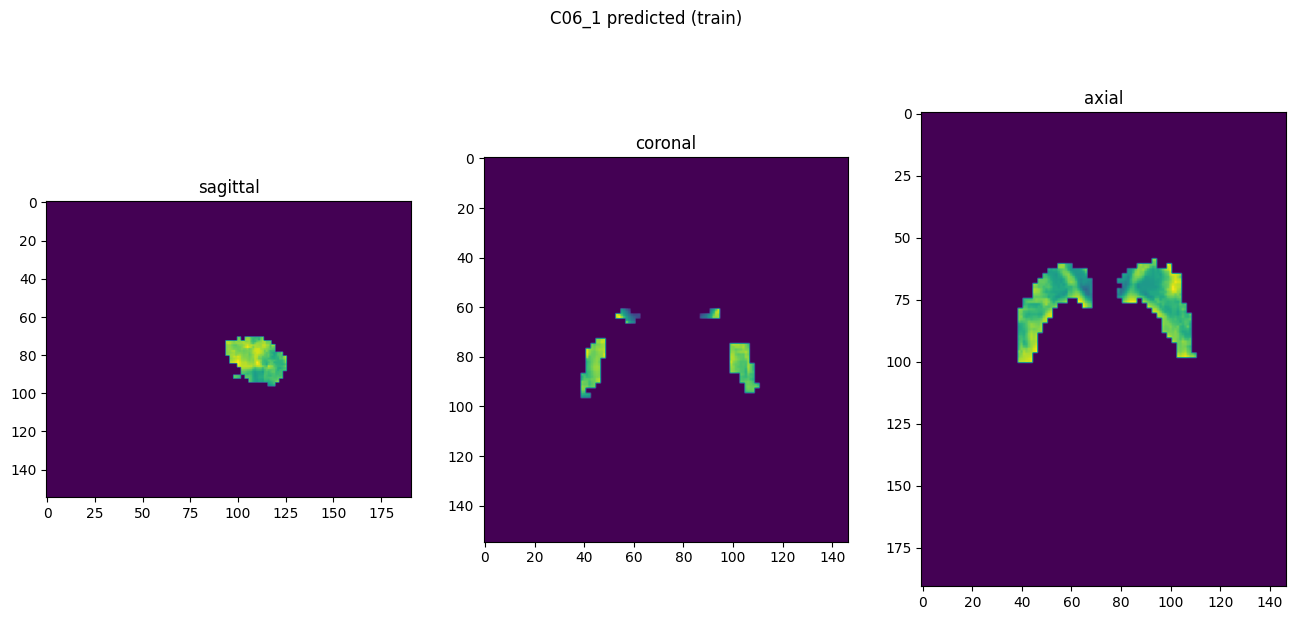

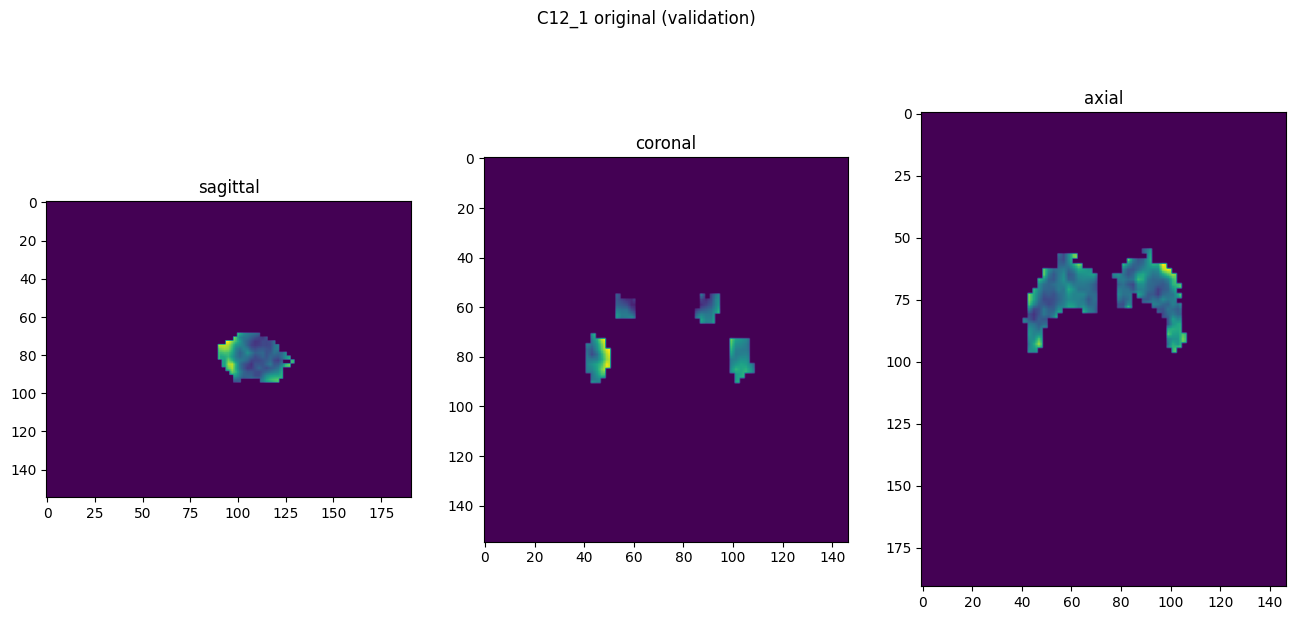

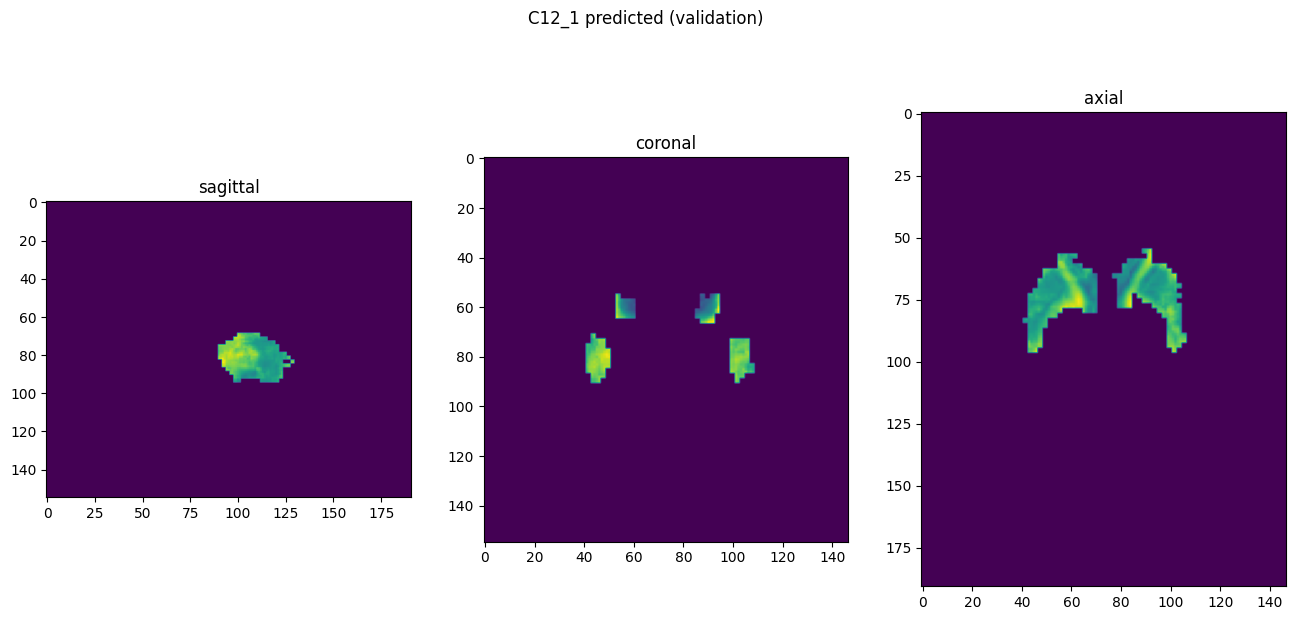

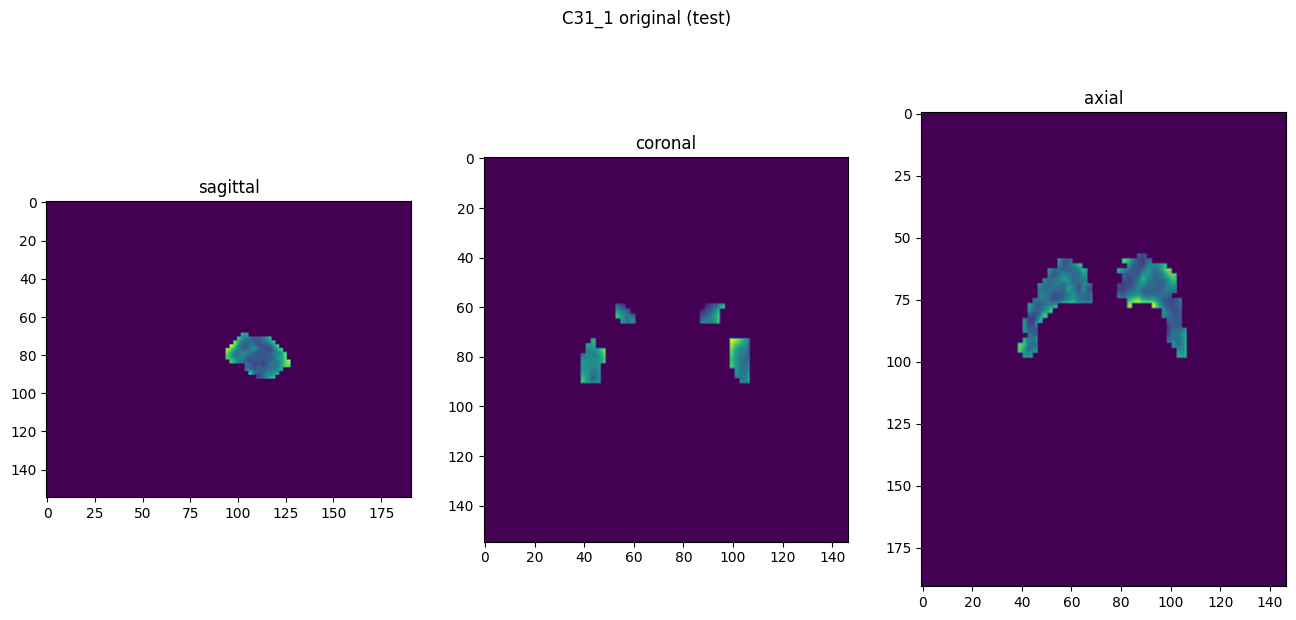

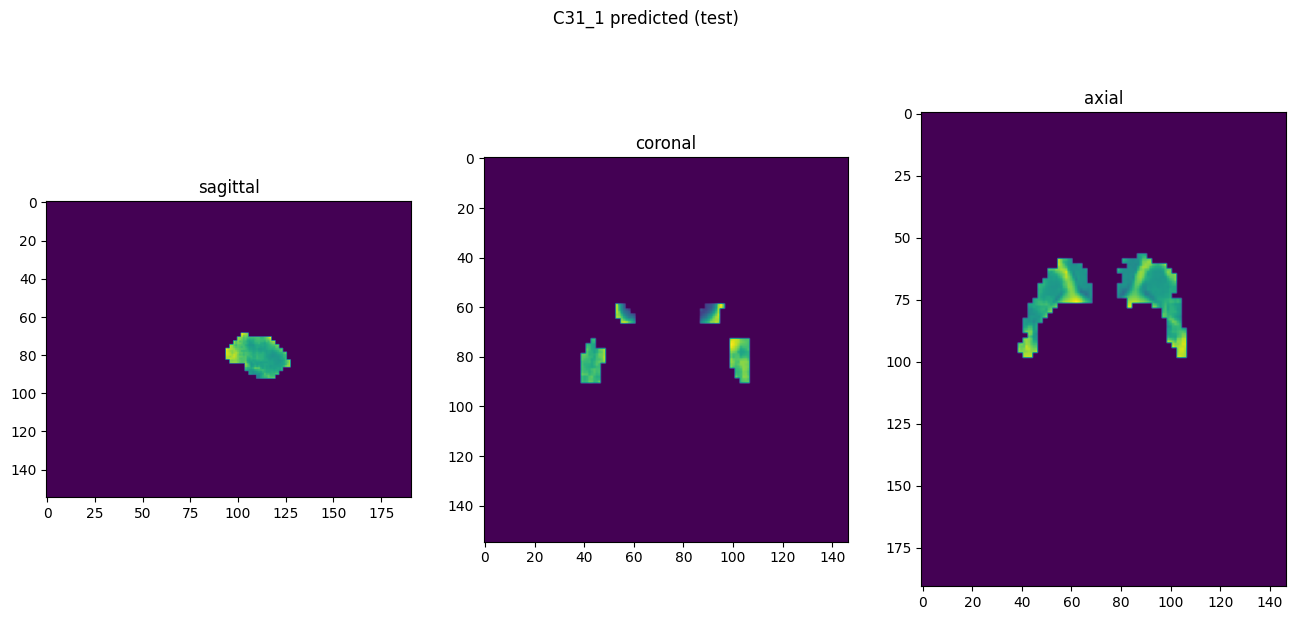

In [10]:
showResults(model, gen, threshold=None, background=False)